In [1]:
import numpy as np
import pandas as pd
import os 

file_dir = '/data/hpa/colon/distance_matrices'
df = pd.DataFrame(columns=['image_a', 'image_b', 'c_dist'])
for cache in os.listdir(file_dir):
    data = np.load(os.path.join(file_dir, cache))
    df = df.append(pd.DataFrame(data, columns=['image_a', 'image_b', 'c_dist']))

In [12]:
df = pd.read_csv('all_inter_gene_pair_cdist.csv')

In [18]:
df = df[df['image_a']!=df['image_b']]
len(df)

811404

In [2]:
metadata_df = pd.read_csv('../data/colon_enhanced.csv')

In [3]:
metadata_df['subcellular_location'].unique()

array(['cytoplasmic/membranous,nuclear', 'none', 'nuclear',
       'cytoplasmic/membranous'], dtype=object)

In [46]:
df['image_a_type'] = df.apply(lambda row: row['image_a'].split('/')[6], axis=1)
df['image_b_type'] = df.apply(lambda row: row['image_b'].split('/')[6], axis=1)
df['type_change'] = df.apply(lambda row: 1 if row['image_a_type']!=row['image_b_type'] else 0, axis=1)

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [57]:
df['staining_change'] = df.apply(lambda row: 1 if row['image_a_staining'].lower()!=row['image_b_staining'].lower() else 0, axis=1)

In [6]:
df = df.merge(metadata_df[['s3_aws_urls', 'subcellular_location']].rename(columns={'s3_aws_urls':'image_a', 'subcellular_location':'image_a_annotation'}), on='image_a')
df = df.merge(metadata_df[['s3_aws_urls', 'subcellular_location']].rename(columns={'s3_aws_urls':'image_b', 'subcellular_location':'image_b_annotation'}), on='image_b')
df = df.merge(metadata_df[['s3_aws_urls', 'staining']].rename(columns={'s3_aws_urls':'image_a', 'staining':'image_a_staining'}), on='image_a')
df = df.merge(metadata_df[['s3_aws_urls', 'staining']].rename(columns={'s3_aws_urls':'image_b', 'staining':'image_b_staining'}), on='image_b')


In [43]:
df['expression_change'] = df.apply(lambda row: 1 if row['image_a_annotation']!=row['image_b_annotation'] else 0, axis=1)
df['c_dist'] = df['c_dist'].astype('float')

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
df.groupby(['image_a_annotation', 'image_b_annotation']).mean()['c_dist']

image_a_annotation              image_b_annotation            
cytoplasmic/membranous          cytoplasmic/membranous            0.121651
                                cytoplasmic/membranous,nuclear    0.125812
                                none                              0.142715
                                nuclear                           0.141535
cytoplasmic/membranous,nuclear  cytoplasmic/membranous            0.125812
                                cytoplasmic/membranous,nuclear    0.118822
                                none                              0.153289
                                nuclear                           0.136807
none                            cytoplasmic/membranous            0.142715
                                cytoplasmic/membranous,nuclear    0.153289
                                none                              0.122096
                                nuclear                           0.140606
nuclear                         cytop

In [31]:
df.to_csv('all_inter_gene_pair_cdist.csv', index=False)

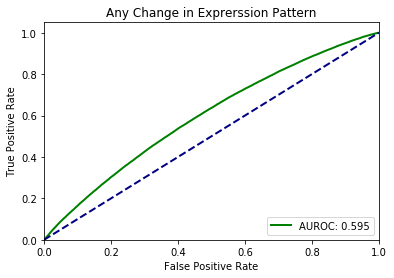

In [32]:
plot_roc_curve(df['expression_change'], df['c_dist'].astype('float'), 'Any Change in Exprerssion Pattern')

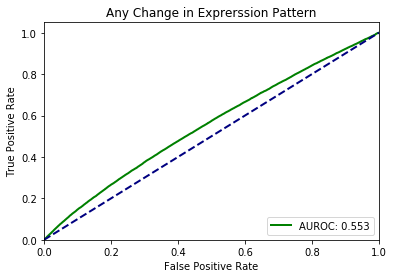

In [59]:
temp_df = df[df['image_a_type']!=df['image_b_type']]
plot_roc_curve(temp_df['expression_change'], temp_df['c_dist'].astype('float'), 'Any Change in Exprerssion Pattern')

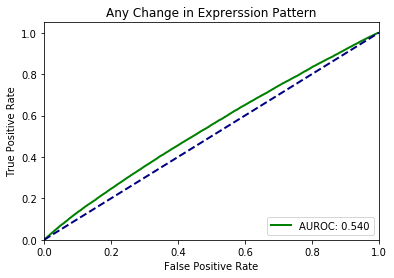

In [61]:
plot_roc_curve(temp_df['staining_change'], temp_df['c_dist'].astype('float'), 'Any Change in Exprerssion Pattern')

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


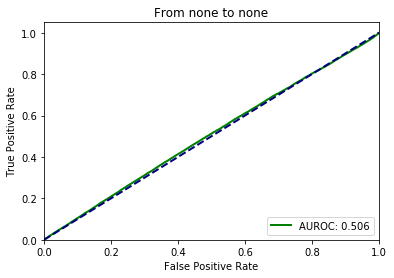

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


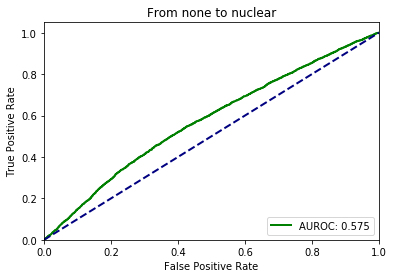

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


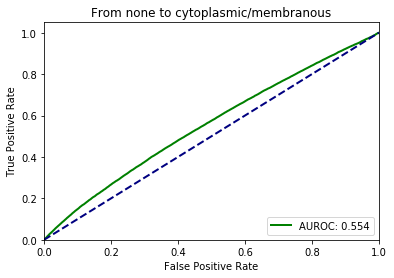

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


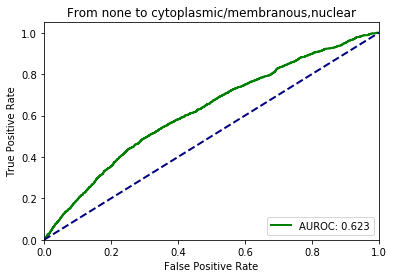

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


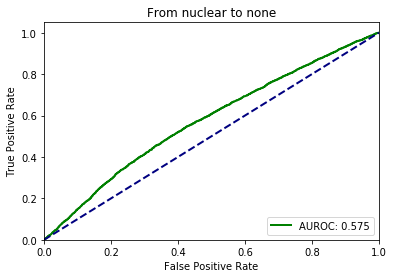

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


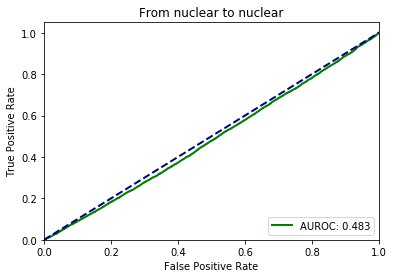

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


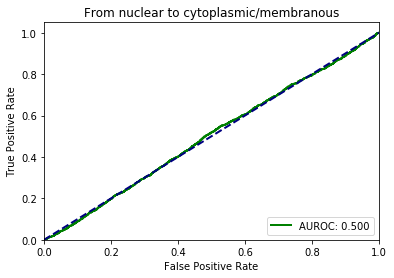

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


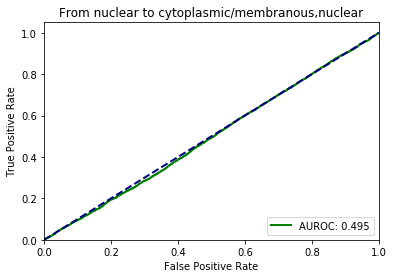

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


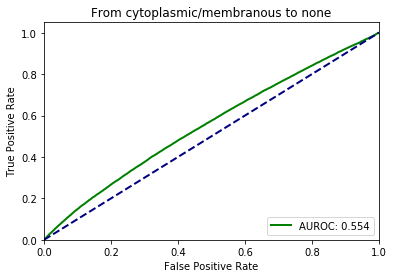

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


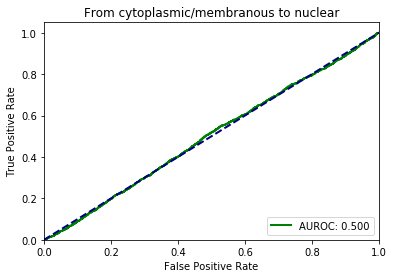

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


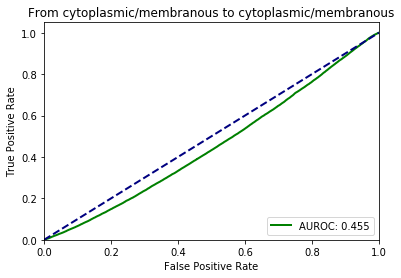

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


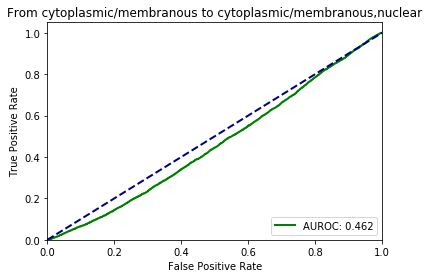

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


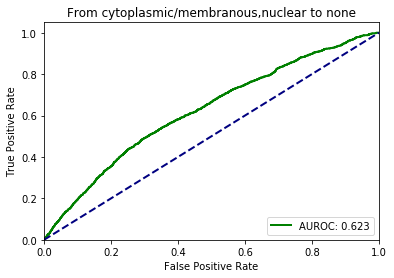

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


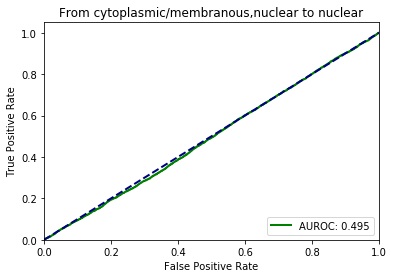

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


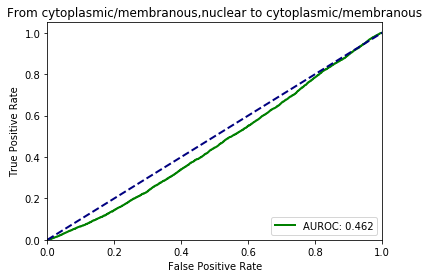

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


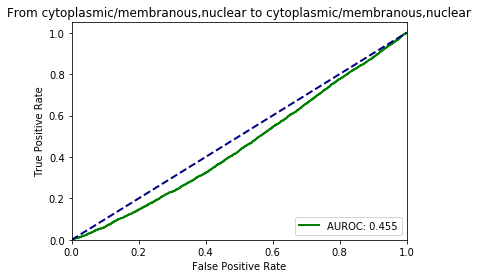

In [56]:
hpa_annotation = ['none', 'nuclear', 'cytoplasmic/membranous', 'cytoplasmic/membranous,nuclear']

for original in hpa_annotation:
    for new in hpa_annotation:
        temp_df['temp'] = df.apply(lambda row: 1 if ((row['image_a_annotation']==original) & 
                                         (row['image_b_annotation']==new)) else 0, axis=1)
        plot_roc_curve(temp_df['temp'], temp_df['c_dist'].astype('float'), 'From {} to {}'.format(original, new))
temp_df = temp_df.drop(columns='temp')       

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


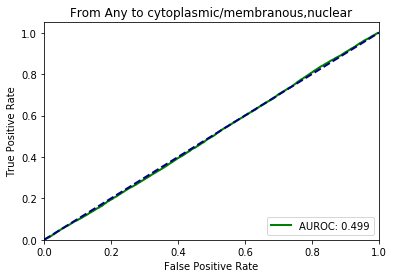

In [62]:
temp_df['temp'] = df.apply(lambda row: 1 if ((row['image_a_annotation']!=new) & 
                                         (row['image_b_annotation']==new)) else 0, axis=1)
plot_roc_curve(temp_df['temp'], temp_df['c_dist'].astype('float'), 'From {} to {}'.format('Any', new))

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


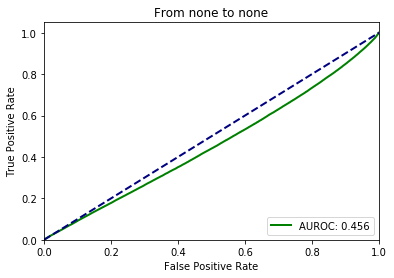

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


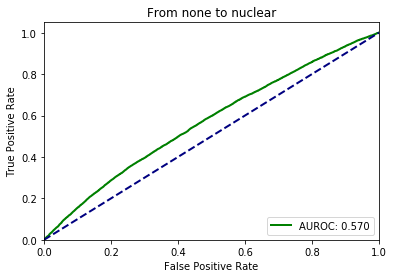

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


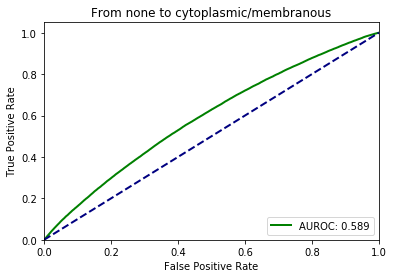

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


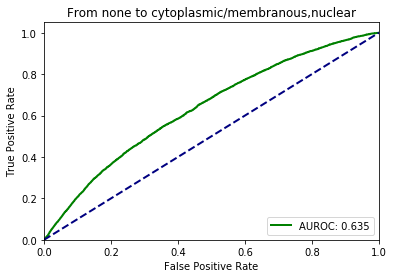

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


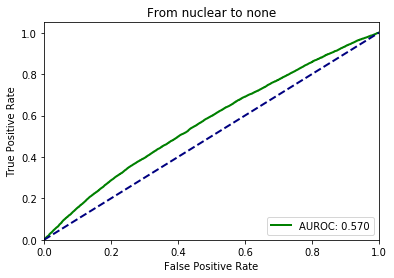

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


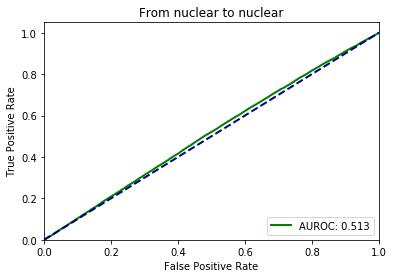

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


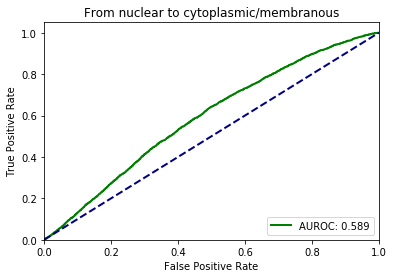

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


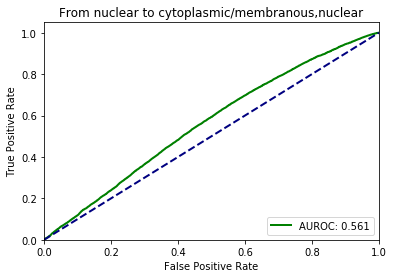

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


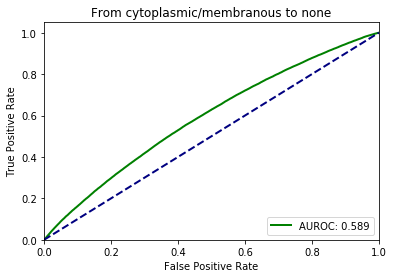

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


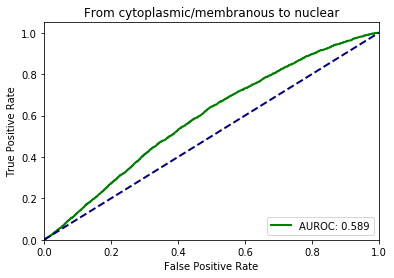

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


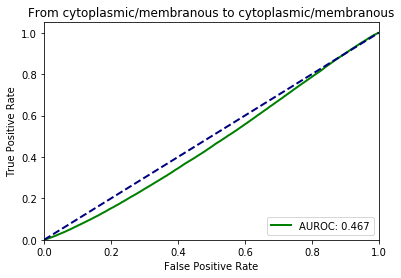

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


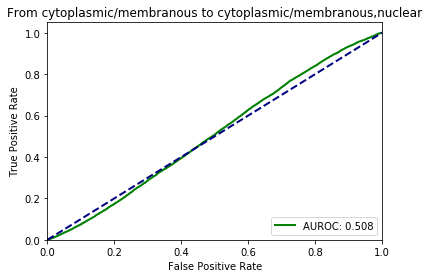

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


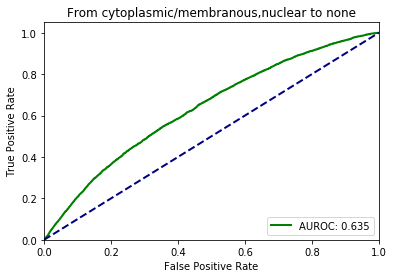

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


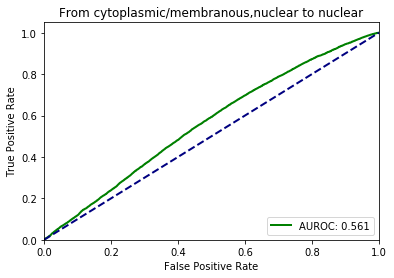

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


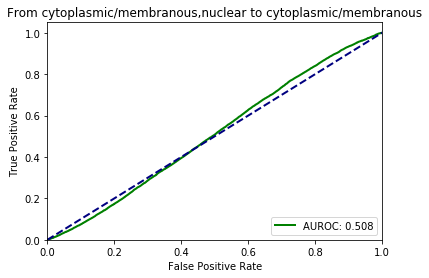

/home/martin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


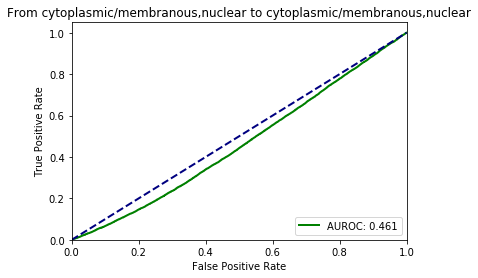

In [33]:
hpa_annotation = ['none', 'nuclear', 'cytoplasmic/membranous', 'cytoplasmic/membranous,nuclear']
for original in hpa_annotation:
    for new in hpa_annotation:
        df['temp'] = df.apply(lambda row: 1 if ((row['image_a_annotation']==original) & 
                                         (row['image_b_annotation']==new)) else 0, axis=1)
        plot_roc_curve(df['temp'], df['c_dist'].astype('float'), 'From {} to {}'.format(original, new))
df = df.drop(columns='temp')    

In [12]:
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, precision_recall_curve


def plot_roc_curve(y_true, y_pred, title):
    plt.figure()
    lw=2
    fpr, tpr, thresh = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, color='green', lw=lw, label='AUROC: {:0.3f}'.format(auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [52]:
annotation_df = df.sample(1000)
annotation_df.groupby(['image_a_annotation', 'image_b_annotation']).count()

image_a  \
image_a_annotation             image_b_annotation                        
cytoplasmic/membranous         cytoplasmic/membranous              304   
                               cytoplasmic/membranous,nuclear        9   
                               none                                 81   
                               nuclear                               2   
cytoplasmic/membranous,nuclear cytoplasmic/membranous               14   
                               cytoplasmic/membranous,nuclear       24   
                               none                                  2   
                               nuclear                              14   
none                           cytoplasmic/membranous               93   
                               cytoplasmic/membranous,nuclear        7   
                               none                                317   
                               nuclear                              10   
nuclear                        cytoplasmic/membranous                3   
                               cytoplasmic/membranous,nuclear       16   
                               none                                 15   
                               nuclear                              89   

                                                               image_b  \
image_a_annotation             image_b_annotation                        
cytoplasmic/membranous         cytoplasmic/membranous              304   
                               cytoplasmic/membranous,nuclear        9   
                               none                                 81   
                               nuclear                               2   
cytoplasmic/membranous,nuclear cytoplasmic/membranous               14   
                               cytoplasmic/membranous,nuclear       24   
                               none                                  2   
                               nuclear                              14   
none                           cytoplasmic/membranous               93   
                               cytoplasmic/membranous,nuclear        7   
                               none                                317   
                               nuclear                              10   
nuclear                        cytoplasmic/membranous                3   
                               cytoplasmic/membranous,nuclear       16   
                               none                                 15   
                               nuclear                              89   

                                                               c_dist  \
image_a_annotation             image_b_annotation                       
cytoplasmic/membranous         cytoplasmic/membranous             304   
                               cytoplasmic/membranous,nuclear       9   
                               none                                81   
                               nuclear                              2   
cytoplasmic/membranous,nuclear cytoplasmic/membranous              14   
                               cytoplasmic/membranous,nuclear      24   
                               none                                 2   
                               nuclear                             14   
none                           cytoplasmic/membranous              93   
                               cytoplasmic/membranous,nuclear       7   
                               none                               317   
                               nuclear                             10   
nuclear                        cytoplasmic/membranous               3   
                               cytoplasmic/membranous,nuclear      16   
                               none                                15   
                               nuclear                             89   

                                                               image_a_staining  \

In [53]:
annotation_df.to_csv('hpa_image_pairs_040520.csv', index=False)